**Install Dependencies**

In [1]:
# %%capture
# !pip install -U torch torchvision torchaudio torcheval
# !pip install -U triton xformers
# !pip install -U diffusers transformers accelerate jupyter huggingface-hub bitsandbytes;
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_kaggle_utils cjm_pandas_utils

**Check diffusers version**

In [2]:
import diffusers
diffusers.__version__

'0.12.1'

In [3]:
from pathlib import Path
import hashlib
import json
import itertools
import multiprocessing
import random
import math
import os
from glob import glob

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset

from PIL import Image
import numpy as np

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, StableDiffusionDepth2ImgPipeline, UNet2DConditionModel
from diffusers import PNDMScheduler
from diffusers.optimization import get_scheduler

from tqdm.auto import tqdm

In [4]:
# Import utility functions
from cjm_kaggle_utils.core import save_kaggle_creds, dl_kaggle
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, iterate_modules, tensor_stats_df, get_torch_device
from cjm_pandas_utils.core import markdown_to_pandas

**Set device and data type**

In [5]:
device = get_torch_device()
dtype = torch.float16 if device == device else torch.float32
device, dtype

('cuda', torch.float16)

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [6]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML Open RAIL++-M License](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work.

* [**Stable Diffusion v2 Depth Model Card**](https://huggingface.co/stabilityai/stable-diffusion-2-depth)

**Select a model**

In [7]:
model_name = "stabilityai/stable-diffusion-2-depth"

**Load autoencoder**

In [8]:
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(device=device, dtype=dtype)

**Load unet**

In [9]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(device=device)

In [10]:
# Try to use xFormers for memory efficient attention
try:
    unet.enable_xformers_memory_efficient_attention()
except:
    print("Unable to use xformers.")

**Load tokenizer**

In [11]:
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer", torch_dtype=dtype)

**Load text encoder**

In [12]:
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(device=device)

**Define training noise scheduler**

In [13]:
train_scheduler = PNDMScheduler.from_pretrained(model_name, subfolder="scheduler")

**Freeze parameters for models not being trained**

In [14]:
# Whether to train the text encoder
train_text_encoder = True

# Freeze the gradients of the VAE model
vae.requires_grad_(False)

# Freeze the gradients of the text encoder if not training it
if not train_text_encoder:
    text_encoder.requires_grad_(False)

**Enable gradient checkpointing**

In [15]:
# Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.
gradient_checkpointing = False

# Enable gradient checkpointing for the U-Net model
if gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    # Enable gradient checkpointing for the text encoder if it is being trained
    if train_text_encoder:
        text_encoder.gradient_checkpointing_enable()

**Enter Kaggle username and API token**

In [16]:
username = ""
key = ""

**Save Kaggle credentials to file**

In [17]:
save_kaggle_creds(username, key, overwrite=False)

Empty username.


**Set directory paths**

In [18]:
# Define path to store datasets
dataset_dir = Path("/mnt/980_1TB_2/Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)
print(f"Dataset Directory: {dataset_dir}")

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)
print(f"Archive Directory: {archive_dir}")

Dataset Directory: /mnt/980_1TB_2/Datasets
Archive Directory: /mnt/980_1TB_2/Datasets/../Archive


**Set Kaggle dataset**

In [19]:
# Set the name of the dataset
dataset_name = 'pexels-110k-512p-min-jpg'
# dataset_name = 'pexels-110k-768p-min-jpg'

# Construct the Kaggle dataset name by combining the username and dataset name
kaggle_dataset = f'innominate817/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
print(f"Archive Path: {archive_path}")

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')
print(f"Dataset Path: {dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/pexels-110k-512p-min-jpg.zip
Dataset Path: /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg


**Download Kaggle dataset**

In [20]:
dl_kaggle(kaggle_dataset, archive_path, dataset_path)

Dataset already downloaded


**Set path to image folder**

In [21]:
img_dir = Path(dataset_path/"images")
img_dir

PosixPath('/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images')

**Get source images**

In [22]:
# Get a list of the paths to the images in the images directory
img_paths = get_img_files(img_dir)

# Print the number of images in the images directory
print(len(img_paths))

109971


**Map image IDs to file paths**

In [23]:
# Create a dictionary mapping image IDs to image paths
img_path_dict = {int(path.stem.split('-')[-1]) : path for path in img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(img_path_dict, orient='index').head()

,0
1061142,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-art-background-1061142.jpg
2586334,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-person-beauty-face-blurred-background-2586334.jpg
1460032,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/1-wtc-artist-concert-1460032.jpg
1061133,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/10-art-artistic-1061133.jpg
1339845,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/images/10-art-color-1339845.jpg


**Set Kaggle depth dataset**

In [24]:
# Set the name of the dataset
depth_dataset_name = f"{dataset_name}-depth"

# Construct the Kaggle dataset name by combining the username and dataset name
depth_kaggle_dataset = f'innominate817/{depth_dataset_name}'

# Create the path to the zip file that contains the dataset
depth_archive_path = Path(f'{archive_dir}/{depth_dataset_name}.zip')
print(f"Archive Path: {depth_archive_path}")

# Create the path to the directory where the dataset will be extracted
depth_dataset_path = Path(f'{dataset_dir}/{depth_dataset_name}')
print(f"Dataset Path: {depth_dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/pexels-110k-512p-min-jpg-depth.zip
Dataset Path: /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-depth


**Download Kaggle dataset**

In [25]:
dl_kaggle(depth_kaggle_dataset, depth_archive_path, depth_dataset_path)

Dataset already downloaded


**Set path to depth image folder**

In [26]:
depth_img_dir = Path(depth_dataset_path/"images")
depth_img_dir

PosixPath('/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-depth/images')

**Get source images**

In [27]:
# Get a list of the paths to the images in the images directory
depth_img_paths = get_img_files(depth_img_dir)

# Print the number of images in the images directory
print(len(depth_img_paths))

109971


**Map image IDs to file paths**

In [28]:
# Create a dictionary mapping image IDs to image paths
depth_img_path_dict = {int(path.stem.split('-')[-1]) : path for path in depth_img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(depth_img_path_dict, orient='index').head()

,0
1000026,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-depth/images/depth-1000026.jpeg
1000037,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-depth/images/depth-1000037.jpeg
1000044,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-depth/images/depth-1000044.jpeg
1000054,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-depth/images/depth-1000054.jpeg
1000056,/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-depth/images/depth-1000056.jpeg


**Store list of image IDs**

In [29]:
img_ids = list(img_path_dict.keys())
len(img_ids)

109971

**Select a subset of image IDs for training**

In [30]:
img_ids_subset = img_ids
img_ids_subset = random.sample(img_ids, 100)
len(img_ids_subset)

100

**Define path to image attribute data**

In [31]:
# Set the file path for the attributes dataframe
attributes_df_json_file = Path(dataset_path/'attributes_df.json')

# Print the file path
print(attributes_df_json_file)

/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/attributes_df.json


**Import image attributes**

In [32]:
# Read the attributes dataframe from the JSON file
attributes_df = pd.read_json(attributes_df_json_file).loc[img_ids_subset]

# Print the number of entries in the dataframe
print(f"Number of entries: {len(attributes_df)}")

# Display the first few rows of the dataframe
attributes_df.head().transpose()

Number of entries: 100


,1786847,1690749,1900203,1859622,2404370
title,Yellow Road Markers,Topless Man Holding Gray Circular Saw,Snowy Field Near Trees Under Golden Hour,Photo Of A Plant,Photo of a Person Snorkeling
aspect_ratio,0.666738,0.666667,0.800212,0.666667,1.500127
main_color,"[111, 100, 90]","[105, 109, 105]","[152, 124, 118]","[149, 154, 145]","[67, 155, 183]"
colors,"[#2f4f4f, #696969, #bc8f8f, #cd853f, #d2b48c]","[#2f4f4f, #5f9ea0, #808080, #d3d3d3]","[#2f4f4f, #696969, #e9967a, #ffdead]","[#000000, #556b2f, #f5f5f5]","[#2f4f4f, #87ceeb]"
tags,"[asphalt, blur, buildings, business, city, crossing, focus, light, low angle shot, markers, outdoors, pavement, pedestrian, pedestrian lane, person, road, street, traffic, traffic lights, transportation system, travel, urban, walking, yellow, zebra crossing]","[biceps, brawny, man, model, muscular, nude, saw, sexy, shirtless, tool]","[beautiful, cold, dawn, environment, evening, frost, frozen, idyllic, landscape, nature, scenic, snow, snow background, snow wallpaper, sunset, weather]","[free wallpaper, HD wallpaper, iphone wallpaper, leaves, mobile wallpaper, plant, plants, samsung wallpaper]","[action, active, adult, blue, corals, deep, dive, diver, diving, fish, fishes, leisure, ocean, people swimming underwater, person, recreation, sea, snorkeling, submerged, summer, swimmer, swimming, travel, tropical, turquoise, underwater, vacation]"
adult,very_unlikely,unlikely,very_unlikely,very_unlikely,very_unlikely
aperture,3.5,2.8,2.4,NaN,7.1
camera,Canon EOS REBEL T5,Canon EOS 5D Mark III,SM-G965F,None,Canon EOS 6D Mark II
focal_length,50.0,150.0,6.0,NaN,17.0
google_place_id,None,None,None,None,None


**Display sample image**

ID: 2888488
Title: Green Trees and Stars
Tags: astronomy, constellation, dark, evening, exploration, grass, landscape, light, night, night sky, outdoors, scenic, silhouette, sky, starry night, starry sky, stars, tree at night, trees


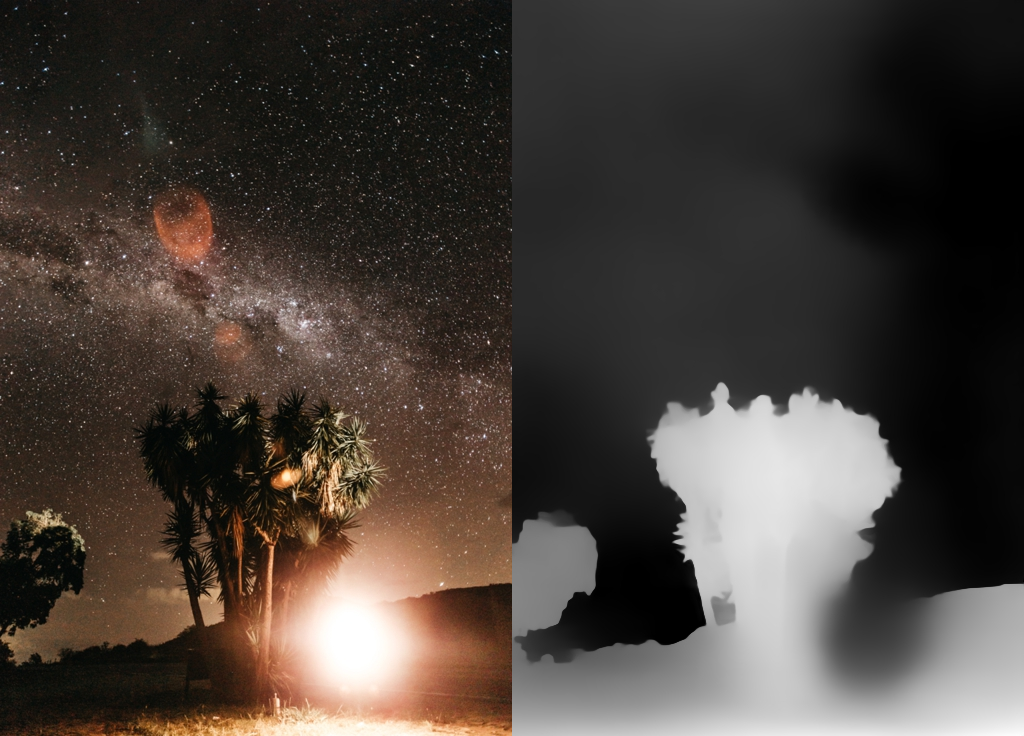

In [33]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids_subset)

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
sample_img = Image.open(img_path_dict[img_id])
depth_img = Image.open(depth_img_path_dict[img_id])

# Print the title of the image, located in the 'title' column of the attributes_df dataframe
print(f"Title: {attributes_df.loc[img_id]['title']}")

# Print the title of the image, located in the 'title' column of the attributes_df dataframe
print(f"Tags: {', '.join(attributes_df.loc[img_id]['tags'])}")

# Display the image
stack_imgs([sample_img, depth_img])

**Set Kaggle latents dataset**

In [34]:
# Set the name of the dataset
latent_dataset_name = f"{dataset_name}-sd2depth-latents"

# Construct the Kaggle dataset name by combining the username and dataset name
latent_kaggle_dataset = f'innominate817/{latent_dataset_name}'

# Create the path to the zip file that contains the dataset
latent_archive_path = Path(f'{archive_dir}/{latent_dataset_name}.zip')
print(f"Archive Path: {latent_archive_path}")

# Create the path to the directory where the dataset will be extracted
latent_dataset_path = Path(f'{dataset_dir}/{latent_dataset_name}')
print(f"Dataset Path: {latent_dataset_path}")

Archive Path: /mnt/980_1TB_2/Datasets/../Archive/pexels-110k-512p-min-jpg-sd2depth-latents.zip
Dataset Path: /mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg-sd2depth-latents


**Download Kaggle dataset**

In [35]:
dl_kaggle(latent_kaggle_dataset, latent_archive_path, latent_dataset_path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4.48G/4.48G [01:27<00:00, 54.9MB/s]


**Define path to image latents**

In [36]:
img_latents_dir = Path(dataset_path.parent/f"{model_name.split('/')[-1]}-{dataset_path.stem}-latents")
img_latents_dir

PosixPath('/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents')

In [37]:
# Get a list of the tensor file paths in the image latents directory
img_latent_paths = glob(os.path.join(img_latents_dir/'tensors', "*.pt"))

print(f"Number of image latents: {len(img_latent_paths)}")

# Display the list of tensor file paths as a DataFrame
pd.DataFrame(img_latent_paths).head()

Number of image latents: 109971


,0
0,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000026.pt
1,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000037.pt
2,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000044.pt
3,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000054.pt
4,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000056.pt


In [38]:
# Create a dictionary mapping image IDs to image latents
img_latent_path_dict = {int(Path(path).stem.split('-')[-1]) : Path(path) for path in img_latent_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(img_latent_path_dict, orient='index').head()

,0
1000026,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000026.pt
1000037,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000037.pt
1000044,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000044.pt
1000054,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000054.pt
1000056,/mnt/980_1TB_2/Datasets/stable-diffusion-2-depth-pexels-110k-512p-min-jpg-latents/tensors/latents-1000056.pt


**Load sample image latents**

In [39]:
sample_img_latent = torch.load(img_latent_path_dict[img_id])
sample_img_latent.shape

torch.Size([1, 4, 92, 64])

**Define dreambooth dataset class**

In [40]:
class FinetuneDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        img_ids,
        img_latent_path_dict,
        depth_img_path_dict,
        prompt_dict,
        tokenizer,
        size=64,
    ):
        self.img_ids = img_ids
        self.size = size
        self.tokenizer = tokenizer

        self.img_latent_path_dict = img_latent_path_dict
        self.depth_img_path_dict = depth_img_path_dict
        self.num_instance_images = len(self.img_ids)
        self.prompt_dict = prompt_dict
        self._length = self.num_instance_images

        self.depth_image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        
        example = {}
        img_id = self.img_ids[index % self.num_instance_images]
        
        latent_path = self.img_latent_path_dict[img_id]
        depth_img_path = self.depth_img_path_dict[img_id]
        
        instance_latent = torch.load(latent_path, map_location='cpu').squeeze()
        depth_image = Image.open(depth_img_path).convert("L")
        
        example["instance_latent"] = instance_latent
        example["instance_depth_images"] = self.depth_image_transforms(depth_image)
        
        prompt = self.prompt_dict[img_id]
        
        example["instance_prompt_ids"] = self.tokenizer(
            prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example

**Set batch size**

In [41]:
# Batch size (per device) for the training dataloader.
bs = 1

**Create a prompt dictionary**

In [54]:
# Define a function that constructs the prompts using the 'title' and 'tags' columns
def construct_prompt(row):
    return row['title']

# def construct_prompt(row):
#     return f"{row.name} {row['title']}"

# def construct_prompt(row):
#     # Check if the 'tags' column is not None
#     if row['tags'] is not None:
#         # If the 'tags' column is not None, return a string that combines the 'title' and 'tags' columns
#         return f"{row['title']}, {', '.join(row['tags'])}"
#     else:
#         # If the 'tags' column is None, return the 'title' column
#         return row['title']

# Apply the 'construct_prompt' function to each row of the DataFrame
# and store the result in a dictionary with keys as image IDs
prompt_dict = attributes_df.apply(construct_prompt, axis=1).to_dict()
prompt_dict[img_id]

'Green Trees and Stars'

**Initialize training dataset**

In [43]:
# This code creates a FinetuneDataset object using the provided arguments.
train_dataset = FinetuneDataset(
    # A list of image IDs to use for the dataset.
    img_ids=img_ids_subset,
    # A dictionary mapping image IDs to their corresponding file paths.
    img_latent_path_dict=img_latent_path_dict,
    depth_img_path_dict=depth_img_path_dict,
    # A dictionary mapping image IDs to their corresponding prompts.
    prompt_dict=prompt_dict,
    # The tokenizer to use for preprocessing the prompts.
    tokenizer=tokenizer,
    # The size of the images to use.
    size=min(sample_img_latent.shape[2:]),
)

**Define custom collate function for training dataloader**

In [44]:
def collate_fn(examples):
    # Collect input_ids and latent_values from the examples
    input_ids = [example["instance_prompt_ids"] for example in examples]
    latent_values = [example["instance_latent"] for example in examples]
    depth_values = [example["instance_depth_images"] for example in examples]
    
    # Stack the latent_values into a single tensor and convert to float
    latent_values = torch.stack(latent_values)
    latent_values = latent_values.to(memory_format=torch.contiguous_format).float()
    
    depth_values = torch.stack(depth_values)
    depth_values = depth_values.to(memory_format=torch.contiguous_format).float()
    
    # Pad input_ids and convert to PyTorch tensor
    input_ids = tokenizer.pad(
        {"input_ids": input_ids},
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt",
    ).input_ids

    # Create batch dictionary
    batch = {
        "input_ids": input_ids,
        "latent_values": latent_values,
        "depth_values": depth_values
    }
    return batch

**Initialize dataloader**

In [45]:
train_dataloader = torch.utils.data.DataLoader(
    # Dataset to use for creating the DataLoader
    train_dataset,
    # Batch size for each training step
    batch_size=bs,
    # Shuffle the dataset before creating batches
    shuffle=True,
    # Function to use for collating examples in the dataset
    collate_fn=collate_fn,
    # Number of worker processes to use for batch generation
    num_workers=multiprocessing.cpu_count(), 
    pin_memory=True
)

**Define training variables**

In [46]:
# Total number of training epochs
# num_train_epochs = 100
num_train_epochs = 50
# Total number of training steps to perform.  If provided, overrides num_train_epochs.
max_train_steps = len(img_ids_subset) * num_train_epochs
# Number of updates steps to accumulate before performing a backward/update pass.
gradient_accumulation_steps = 1

**Define learning rate variables**

In [47]:
# Initial learning rate (after the potential warmup period) to use.
learning_rate = 1e-6
# Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.
scale_lr = False
# The scheduler type to use. 
# Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"]
lr_scheduler = "constant"
# Number of steps for the warmup in the lr scheduler.
lr_warmup_steps = 0

**Scale learning rate**

In [48]:
# Scale the learning rate based on the gradient accumulation steps and batch size
if scale_lr: learning_rate = learning_rate * gradient_accumulation_steps * bs

**Define which model parameters to optimize**

In [49]:
params_to_optimize = (
    itertools.chain(unet.parameters(), text_encoder.parameters()) 
    if train_text_encoder else unet.parameters()
)

**Initialize optimizer**

In [50]:
# Use 8-bit Adam for lower memory usage when available
# https://github.com/TimDettmers/bitsandbytes
try:
    import bitsandbytes as bnb
    optimizer_class = bnb.optim.AdamW8bit
except ImportError:
    optimizer_class = torch.optim.AdamW

# Print the name of the optimizer class
print(f"Optimizer Class: {optimizer_class.__name__}")

# Create an optimizer instance with the specified learning rate
optimizer = optimizer_class(params_to_optimize, lr=learning_rate, eps=1e-5)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
Optimizer Class: AdamW8bit


**Define learning rate scheduler**

In [51]:
# Create a learning rate scheduler
lr_scheduler = get_scheduler(
    # Scheduler type
    lr_scheduler,
    # Optimizer to use for learning rate scheduling
    optimizer=optimizer,
    # Number of warmup steps
    num_warmup_steps=lr_warmup_steps * gradient_accumulation_steps,
    # Total number of training steps
    num_training_steps=max_train_steps * gradient_accumulation_steps,
)

In [52]:
# total_steps = max_train_steps * gradient_accumulation_steps
# steps_per_epoch = math.ceil(total_steps/num_train_epochs/bs)

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
#                                                    max_lr=learning_rate, 
#                                                    steps_per_epoch=steps_per_epoch, 
#                                                    epochs=num_train_epochs,)

**Finetune model**

In [ ]:
# Set the text encoder and U-Net model to floating point
text_encoder = text_encoder.float()
unet = unet.float()

# Initialize gradient scaler
scaler = torch.cuda.amp.GradScaler()

for epoch in tqdm(range(num_train_epochs)):
    unet.train()
    if train_text_encoder: text_encoder.train()
        
    agg_loss = 0
    
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(len(train_dataloader)))
    progress_bar.set_description("Steps")
        
    for step, batch in enumerate(train_dataloader):
        
        # Convert images to latent space
#         latents = vae.encode(batch["pixel_values"].to(device=device, dtype=dtype)).latent_dist.sample()
#         latents = latents * 0.18215
        latents = batch["latent_values"].to(device=device, dtype=dtype)

        # Sample noise that we'll add to the latents
        noise = torch.randn(latents.shape, device=device, dtype=latents.dtype)
        
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, train_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_latents = train_scheduler.add_noise(latents, noise, timesteps)
        
        noisy_latents = torch.cat([noisy_latents, batch["depth_values"].type_as(noisy_latents)], dim=1)

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"].to(device=device))[0]
        
        # Run forward pass under autocast
        with torch.cuda.amp.autocast():

            # Predict the noise residual
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            
            if train_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif train_scheduler.config.prediction_type == "v_prediction":
                target = train_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {train_scheduler.config.prediction_type}")
            
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
                
            # Scale loss value based on number of accumulation steps
            loss = loss / gradient_accumulation_steps
            
        # Scale loss
        scaler.scale(loss).backward()
        
        # Gradient accumulation
        if (step + 1) % gradient_accumulation_steps == 0:
            
            # Unscale gradients
            scaler.step(optimizer)
            # Update scale
            scaler.update()
            # Reset gradients
            optimizer.zero_grad(set_to_none=True)
        
            lr_scheduler.step()
        
        # Update progress bar
        progress_bar.update(1)
        
        agg_loss += loss.detach().item()
        
        logs = {"loss": loss.detach().item(), 
                "avg_loss": agg_loss/(step+1), 
                "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        
# Releases all unoccupied cached memory
torch.cuda.empty_cache()

**Define save path for finetuned models**

In [52]:
# Create a directory for the finetune checkpoints
finetune_dir = Path("./finetune_checkpoints")
finetune_dir.mkdir(parents=True, exist_ok=True)

# Create a directory for the specific checkpoints
checkpoint_dir = Path(finetune_dir/f"pexels_samples_{len(img_ids_subset)}_epochs_{num_train_epochs}-depth")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Print the path to the checkpoint directory
checkpoint_dir

PosixPath('finetune_checkpoints/pexels_samples_100_epochs_50-depth')

**Prepare unet and text encoder for inference**

In [53]:
# Set the U-Net and text encoder models to half-precision floating point
unet.half();
text_encoder.half();

# Set the U-Net and text encoder models to evaluation mode
unet.eval();
text_encoder.eval();

**Save finetuned models**

In [54]:
# Create the pipeline using using the trained modules and save it.
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    model_name,
    unet=unet,
    text_encoder=text_encoder,
    torch_dtype=dtype
).to(device)

pipe.save_pretrained(checkpoint_dir)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [55]:
# Create a file for storing the image IDs of the images in the training set
ckpt_img_ids_path = Path(checkpoint_dir/"img_ids.txt")

# Write the image IDs to the file
with open(ckpt_img_ids_path, "w") as write_file:
    for img_id in img_ids_subset:
        write_file.write(f"{img_id}\n")